### <center> This notebook has the postprocess of raw Level 4 altimetry data and the following construction of a sea level dataset for the tropical band and the coastal bands of the south east and north east pacific.


The data used will be the L4 ongoing sea level anomalies product of marine copernicus ("Global Ocean Gridded L 4 Sea Surface Heights And Derived Variables Reprocessed 1993 Ongoing). The global grid sea level is obtained by an interpolation of several altimeter missions (TOPEX, Jason, Sentinel, etc). The product contains sea level anomalies with respect to a twenty-year (1993-2012) mean. 

In [2]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [3]:
# Load altimeter grid masks (same as 0.25° ASCAT)
mask = xr.open_dataset('data/TOPEX_masks.nc')

In [31]:
# Load scatterometer data

# ASCAT
path = [glob(f'data/ALTIMETRIA/dt_global_allsat_phy_l4_{yr}*.nc') for yr in range(1999,2021+1)]
path = sorted(sum(path,[]))

def preprocess(data):
    print(data.time.dt.strftime('%F').data)
    data = data.rename({'latitude':'lat','longitude':'lon'}).squeeze()
    data = data[['sla']].rename({'sla':'zos'})
    data = data.sel(lat=slice(-45,45))
    data = data.sortby('lon').sel(lon=slice(110,291))
    return data.compute()

altim = xr.open_mfdataset(path, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)

['2021-03-19']
['2020-09-19']
['2020-06-28']
['2020-10-07']
['2011-05-28']
['2009-11-01']
['2013-05-24']
['2007-05-27']
['2011-04-30']
['2004-08-29']
['2009-09-07']
['2001-09-04']
['2010-05-26']
['2016-07-11']
['2017-01-25']
['2002-05-10']
['2000-05-11']
['2019-05-15']
['2012-07-05']
['2005-10-27']
['2009-05-14']
['1999-10-19']
['2019-11-11']
['2014-06-29']
['2013-04-17']
['2004-07-10']
['2014-11-23']
['2016-07-04']
['1999-10-22']
['1999-07-19']
['2008-03-12']
['2009-12-25']
['2006-11-30']
['2006-04-08']
['2005-02-14']
['2001-05-16']
['2003-12-10']
['2007-12-09']
['2010-11-11']
['2015-01-29']
['2018-10-17']
['2003-06-26']
['2018-06-30']
['2003-06-23']
['2015-08-22']
['2021-06-11']
['2020-10-03']
['2021-08-14']
['2013-11-21']
['2021-12-25']
['2021-03-09']
['2005-06-15']
['2010-05-09']
['2011-04-28']
['2020-11-24']
['2020-12-23']
['2003-01-15']
['2008-07-10']
['2006-04-09']
['2014-01-20']
['2012-07-02']
['2013-08-13']
['2014-12-02']
['2014-12-03']
['2017-11-23']
['2019-07-21']
['2017-06-

---

##### Tropical hovmoller

In [85]:
# Build tropical hovmoller
tropical = altim.sel(lat=slice(-3,3),lon=slice(mask.lon.min(),mask.lon.max()))
tropical = tropical.where(mask.tropicalmask==1).mean('lat')
tropical = tropical.dropna('lon') # Drop all land nans
tropical

<xarray.Dataset>
Dimensions:  (time: 8401, lon: 566)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-12-31
  * lon      (lon) float32 140.1 140.4 140.6 140.9 ... 280.6 280.9 281.1 281.4
Data variables:
    zos      (time, lon) float64 -0.01976 -0.01782 -0.01439 ... 0.1103 0.1114

---

##### Build coastal hovmollers

In [86]:
# north
coastnorth = altim.sel(lon=slice(230,295), lat=slice(0,50))
coastnorth = coastnorth.where(mask.coastmask_north==1).mean('lon')
coastnorth = coastnorth.dropna('lat')
coastnorth

<xarray.Dataset>
Dimensions:  (time: 8401, lat: 152)
Coordinates:
  * lat      (lat) float64 2.125 2.375 2.625 2.875 ... 39.12 39.38 39.62 39.88
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-12-31
Data variables:
    zos      (time, lat) float64 -0.05865 -0.05217 -0.04995 ... 0.1283 0.1062

In [87]:
# south
coastsouth = altim.sel(lon=slice(260,295), lat=slice(-50,0))
coastsouth = coastsouth.where(mask.coastmask_south==1).mean('lon')
coastsouth = coastsouth.dropna('lat').sortby('lat', ascending=False)
coastsouth

<xarray.Dataset>
Dimensions:  (time: 8401, lat: 152)
Coordinates:
  * lat      (lat) float64 -2.125 -2.375 -2.625 -2.875 ... -39.38 -39.62 -39.88
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-12-31
Data variables:
    zos      (time, lat) float64 -0.08928 -0.09175 -0.08525 ... 0.05092 0.0594

---

##### Add coordinate and metadata

In [88]:
def haversine(p1,p2):
    """
    Given two points with lat,lon coordinates, compute the distance
    between those points on the surface of the sphere with the haversine formula
    Args:
        p1 (tuple): first point lat,lon
        p2 (tuple): last point lat,lon

    Returns:
        float: distance
    """
    lat1,lon1 = p1
    lat2,lon2 = p2

    lon1,lon2,lat1,lat2 = map(np.deg2rad, [lon1,lon2,lat1,lat2])

    dlon = lon2-lon1
    dlat = lat2-lat1

    a = np.sin(dlat/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

def distances(data, lon_name='lon', lat_name='lat'):
    """
    This function uses the haversine formula to build a 
    distance vector based on the latitude and longitude
    of the hovmoller data contained in xarray format.
    Args:
        data (xarray.Dataset): 
        Data set with the coastal or coastnorth hovmoller

    Returns:
        np.array: distances in km
    """
    distance = []
    for i in range(len(data[lon_name].values)-1):
        lon1,lat1 = data[lon_name].values[i], data[lat_name].values[i]
        lon2,lat2 = data[lon_name].values[i+1], data[lat_name].values[i+1]
        dist = haversine(p1=(lat2,lon2), p2=(lat1,lon1))
        distance.append(dist)
    distance = np.hstack([np.array([0]),np.array(distance)])
    distance = np.cumsum(distance)
    return distance
    

In [89]:
# Find longitude of each coastal american pixel
lon,lat = np.meshgrid(mask.lon,mask.lat)
coastnorthcoords   = pd.DataFrame((lon[0,:],np.zeros(len(lon[0,:]))), index=['lon','lat']).T
lonn = []
lons = []
for i in range(len(mask.lat)):
    try:
        x = mask.coastmask_north.where(mask.coastmask_north==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lonn.append(x)
    except:
        lonn.append(np.nan)
        pass
    
    try:
        x = mask.coastmask_south.where(mask.coastmask_south==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lons.append(x)
    except:
        lons.append(np.nan)
        pass
coastnorthcoords = pd.DataFrame((np.array(lonn),lat[:,0]),index=['lon','lat']).T.dropna()
coastsouthcoords = pd.DataFrame((np.array(lons),lat[:,0]),index=['lon','lat']).T.dropna()

coastnorthcoords.index = coastnorthcoords.lat
coastsouthcoords.index = coastsouthcoords.lat

coastnorthcoords = coastnorthcoords.loc[coastnorth.lat.values]
coastsouthcoords = coastsouthcoords.loc[coastsouth.lat.values]

In [90]:
# Assign the position along lons as a new spatial dimension/coordinate
tropical = tropical.assign_coords({'index':('lon',range(len(tropical.lon)))})
tropical = tropical.swap_dims({'lon':'index'}) # Make the position in the grid as the main coordinate
tropical = tropical.assign_coords({'lat':('index', np.zeros(len(tropical.index)))}) # Add latitudes

# Same but for coastnorth array
coastnorth = coastnorth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastnorth.lat)))}) # Add the position coordinate as the continuity of the coastnorth one
coastnorth = coastnorth.swap_dims({'lat':'index'})
coastnorth = coastnorth.assign_coords({'lon':('index', coastnorthcoords.lon.values)})

# Same but for coastsouth array
coastsouth = coastsouth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastsouth.lat)))}) # idem
coastsouth = coastsouth.swap_dims({'lat':'index'})
coastsouth = coastsouth.assign_coords({'lon':('index', coastsouthcoords.lon.values)})

In [91]:
# Assign distance as new coordinate for the tropical hovmoller
tropical = tropical.assign_coords({'distance':('index',distances(tropical))})
tropical = tropical.swap_dims({'index':'distance'})
tropical = tropical[['time','distance','lat','lon','index','zos']]

# Assign distance as new coordinate for the coastnorth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastnorth.lat[0].item(),coastnorth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastnorth = coastnorth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastnorth))})
coastnorth = coastnorth.swap_dims({'index':'distance'})
coastnorth = coastnorth[['time','distance','lat','lon','index','zos']]

# Assign distance as new coordinate for the coastsouth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastsouth.lat[0].item(),coastsouth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastsouth = coastsouth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastsouth))})
coastsouth = coastsouth.swap_dims({'index':'distance'})
coastsouth = coastsouth[['time','distance','lat','lon','index','zos']]

In [92]:
dummy = xr.open_dataset('data/ALTIMETRIA/dt_global_allsat_phy_l4_19930101.nc') # dummy dataset with some attributes

# Global attributes
tropical_attrs   = {'name':'Tropical Hovmoller of multi-altimeter sea level',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'Sea level average along the tropical band (2°S - 2°N)',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl',
                    'long_name':'DT merged all satellites Global Ocean Gridded SSALTO/DUACS Sea Surface Height L4 product and derived variables'}
coastnorth_attrs = {'name':'Coastal Hovmoller of multi-altimeter sea level for the North East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'Sea level average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastsouth_attrs = {'name':'Coastal Hovmoller of multi-altimeter sea level for the South East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'Sea level average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}

# Common variable attributes
zos_attrs        = dummy.sla.attrs
lon_attrs        = dummy.longitude.attrs
lat_attrs        = dummy.latitude.attrs
time_attrs       = dummy.time.attrs
index_attrs      = {'long_name':'Position along the spatial dimension of the hovmoller grid',
                    'short_name':'index',
                    'units':'(-)'}
distance_attrs   = {'long_name':'Distance along the spatial dimension of the hovmoller grid',
                    'short_name':'distance',
                    'units':'km'}

In [93]:
# Assign attributes 
tropical.attrs          = tropical_attrs
tropical.zos.attrs      = zos_attrs
tropical.lon.attrs      = lon_attrs
tropical.lat.attrs      = lat_attrs
tropical.index.attrs    = index_attrs
tropical.distance.attrs = distance_attrs

coastnorth.attrs          = coastnorth_attrs
coastnorth.zos.attrs      = zos_attrs
coastnorth.lon.attrs      = lon_attrs
coastnorth.lat.attrs      = lat_attrs
coastnorth.index.attrs    = index_attrs
coastnorth.distance.attrs = distance_attrs

coastsouth.attrs          = coastsouth_attrs
coastsouth.zos.attrs      = zos_attrs
coastsouth.lon.attrs      = lon_attrs
coastsouth.lat.attrs      = lat_attrs
coastsouth.index.attrs    = index_attrs
coastsouth.distance.attrs = distance_attrs

In [94]:
# Save data into disk
tropical.to_netcdf('./data/HOVMOLLERS/SEALEVEL_hovmoller_tropical_1999-2021.nc')
coastnorth.to_netcdf('./data/HOVMOLLERS/SEALEVEL_hovmoller_coastnorth_1999-2021.nc')
coastsouth.to_netcdf('./data/HOVMOLLERS/SEALEVEL_hovmoller_coastsouth_1999-2021.nc')

Text(0, 0.5, 'Tropical - South America Coast')

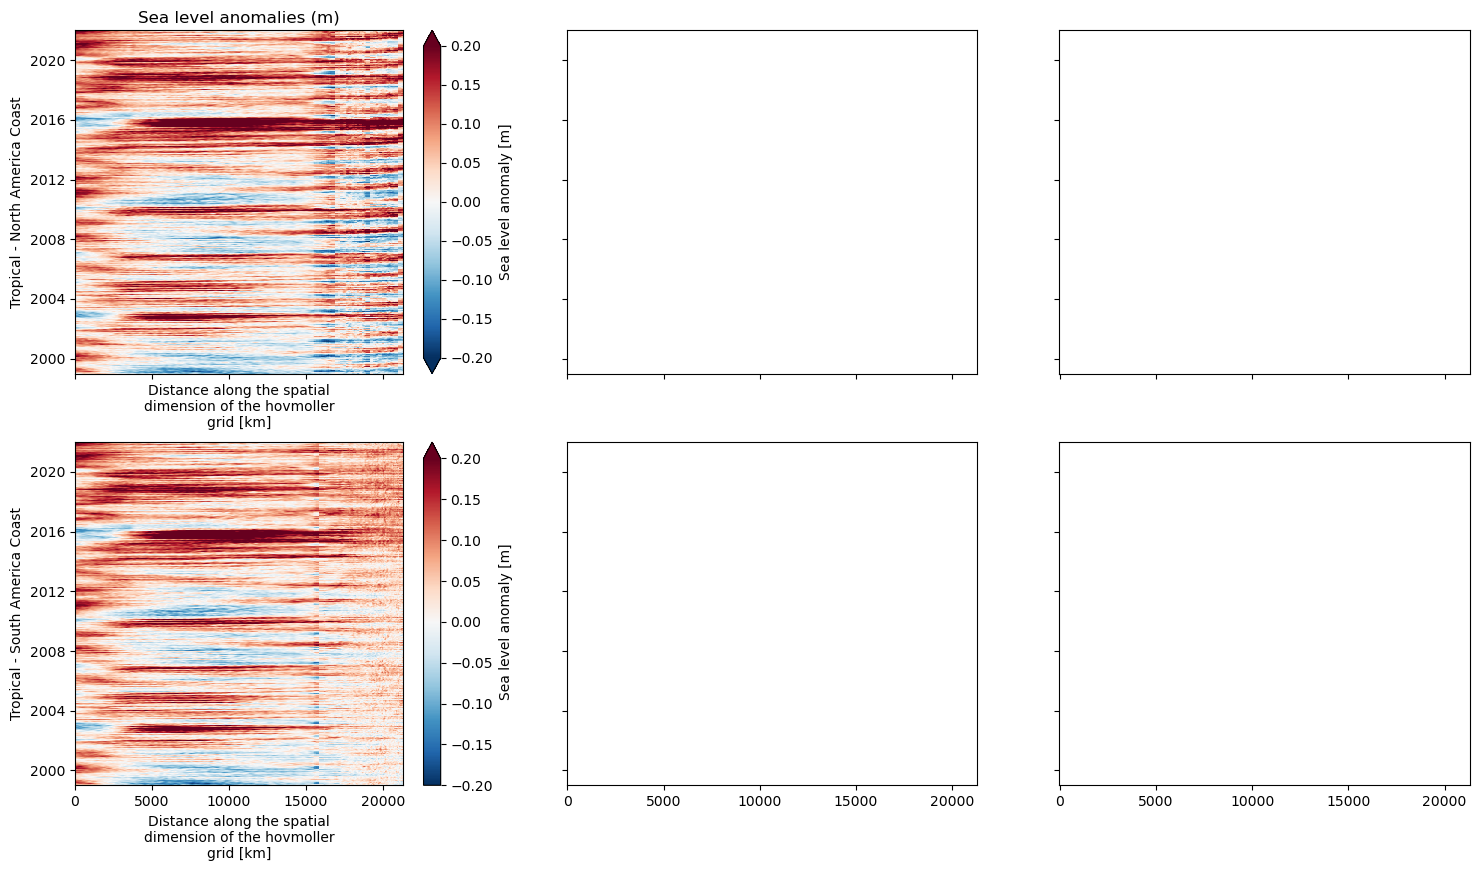

In [100]:
# Quicklook to the hovmollers
fig, ax = plt.subplots(2,3, figsize=(18,10), dpi=100, facecolor='w',
                       sharex=True, sharey=True)

xr.concat([tropical,coastnorth], 'distance').zos.plot(ax=ax[0,0], vmin=-0.2, vmax=0.2, cmap='RdBu_r')
xr.concat([tropical,coastsouth], 'distance').zos.plot(ax=ax[1,0], vmin=-0.2, vmax=0.2, cmap='RdBu_r')


ax[0,0].set_title('Sea level anomalies (m)')

ax[0,0].set_ylabel('Tropical - North America Coast')
ax[1,0].set_ylabel('Tropical - South America Coast')